## Meaningful Metrics: Cumulative Gains and Lyft Charts

Author: [**Raffi Sahakyan**](https://www.linkedin.com/in/raffi-sahakyan)
MS in Business Aanlytics Candidate at UCLA Anderson

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Objectives
* Introduce Cumulative Gains and Lift Charts

In [156]:
#Basic use libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#ML Model
from sklearn.ensemble import RandomForestClassifier

#Metrics
from sklearn.metrics import recall_score, roc_auc_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#ScikitPlot Metrics
import scikitplot as skplt 


# to ignore warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# magic to not to call show every time 
%matplotlib inline
plt.style.use("ggplot")

In [188]:
churn_raw = pd.read_excel("https://github.com/raffisahakyan/Raw_Data/blob/master/Churn%20(1).xls?raw=true")

In [189]:
churn_raw.head(2)

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,...,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,...,45.07,99,16.78,91,11.01,3,2.7,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,...,27.47,103,16.62,103,11.45,3,3.7,OH,415,371-7191


In [159]:
churn_raw.info()
#I will transform the data before applying models
#It is important to note that there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Eve Mins          3333 non-null float64
Night Mins        3333 non-null float64
Intl Mins         3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
State             3333 non-null object
Area Code         3333 non-null int64
Phone             3333 non-null object
dtypes: float64(8), int64(11), object(2)
memory usage: 546.9+ KB


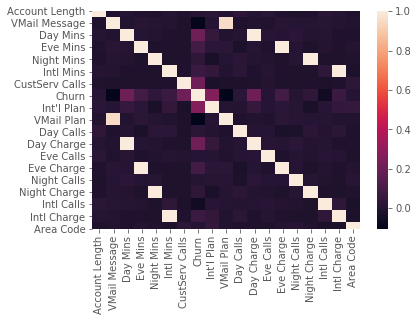

In [160]:
churn_no_object = churn_raw.select_dtypes(exclude=["object"])
sns.heatmap(churn_no_object.corr())
plt.show()

In [161]:
#Benchmarking
churn_raw.Churn.value_counts()/len(churn_raw)*100

0    85.508551
1    14.491449
Name: Churn, dtype: float64

In [162]:
churn_raw[['Day Mins','Day Charge']].corr(method='pearson', min_periods=1)
#This means that 'Day Mins' and 'Day Charge columns are perfectly correlated, 
#So we can drop 'Day Mins' column.

,Day Mins,Day Charge
Day Mins,1.0,1.0
Day Charge,1.0,1.0


In [163]:
churn_raw[['Eve Mins','Eve Charge']].corr(method='pearson', min_periods=1)
#This means that 'Eve Mins' and 'Eve Charge columns are perfectly correlated, 
#So we can drop 'Eve Mins' column.

,Eve Mins,Eve Charge
Eve Mins,1.0,1.0
Eve Charge,1.0,1.0


In [164]:
churn_raw[['Night Mins','Night Charge']].corr(method='pearson', min_periods=1)
#This means that 'Night Mins' and 'Night Charge columns are perfectly correlated, 
#So we can drop 'Night Mins' column.

,Night Mins,Night Charge
Night Mins,1.000000,0.999999
Night Charge,0.999999,1.000000


In [165]:
churn_raw[['VMail Message','VMail Plan']].corr(method='pearson', min_periods=1)
#I consider to drop 'VMail Message' column also, 
#However I will reconsider this choice after developing models. 

,VMail Message,VMail Plan
VMail Message,1.000000,0.956927
VMail Plan,0.956927,1.000000


In [166]:
churn_raw[['Intl Mins','Intl Charge']].corr(method='pearson', min_periods=1)
#This means that 'Intl Mins' and 'Intl Charge' columns are perfectly correlated,
#So we can drop 'Night Mins' column. 

,Intl Mins,Intl Charge
Intl Mins,1.000000,0.999993
Intl Charge,0.999993,1.000000


In [167]:
#Besides above mentioned columns, I will also drop 'State', 'Area Code' and 'Phone Number' columns, since those
#do not make sense in the churn analysis. 
churn_clear = churn_raw.drop(['State','Area Code','Phone','Day Charge','Eve Charge',
                              'Night Charge','Intl Charge'], axis=1)
churn_clear.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,Day Calls,Eve Calls,Night Calls,Intl Calls
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,99,91,3
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,103,103,3
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,110,104,5
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,88,89,7
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,122,121,3


In [168]:
#train test split and x,y estimation
y = churn_clear.Churn
x = churn_clear.drop("Churn",axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42, stratify=y)

In [169]:
#Modals with default parameters and unscaled data
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [170]:
#Accuracy scores on train and test sets
print(model_rf.score(x_train,y_train)*100)
print(model_rf.score(x_test,y_test)*100)

99.63985594237695
92.44604316546763


In [171]:
rf_pred = model_rf.predict(x_test)
print(mean_squared_error(y_test,rf_pred))

0.07553956834532374


In [172]:
#roc auc scores for default parameter models
print(roc_auc_score(y_test,rf_pred)*100)

77.74100819491615


In [173]:
#recall scores for default parameter models
print(recall_score(y_test,rf_pred)*100)

57.02479338842975


In [174]:
#cv's for default parameter models
print(cross_val_score(model_rf,x,y,cv=10))

[0.94011976 0.94011976 0.9251497  0.92492492 0.94894895 0.93693694
 0.95195195 0.93693694 0.92792793 0.94594595]


In [175]:
print(cross_val_score(model_rf,x,y,cv=10).std())

0.009090370277449748


### Random Forest - Tuning

In [176]:
#Firstly we can try with best parameters from DT
model_rf_good = RandomForestClassifier(max_depth = 6, min_samples_leaf = 4,
                                       class_weight="balanced",min_samples_split=6, 
                                       random_state=42)
model_rf_good.fit(x_train, y_train)
print(model_rf_good.score(x_train,y_train)*100)
print(model_rf_good.score(x_test,y_test)*100)
print(cross_val_score(model_rf_good,x,y,cv=10).std())

93.27731092436974
88.00959232613909
0.016717154887464395


In [177]:
rf_good_pred = model_rf_good.predict(x_test)
print(roc_auc_score(y_test,rf_good_pred)*100)
print(recall_score(y_test,rf_good_pred)*100)
print(mean_squared_error(y_test,rf_good_pred))

80.97898531406116
71.07438016528926
0.11990407673860912


In [178]:
#I will apply gridsearch for this one as well.
param_grid_values = {'max_depth': [i for i in range(2,19)], 
                     'min_samples_leaf': [3,4,6,7,9,10],
                     'min_samples_split': [z for z in range(4,21,2)]}

In [179]:
grid_search_rf = GridSearchCV(estimator = model_rf,
                              param_grid = param_grid_values, 
                              scoring='roc_auc',cv=2,n_jobs=2)
grid_search_rf.fit(x_train,y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'max_dep

In [180]:
grid_search_rf.best_params_

{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 10}

In [181]:
model_rf_best_params = RandomForestClassifier(max_depth = 10, min_samples_leaf = 6, 
                                              min_samples_split = 20, random_state=42)
model_rf_best_params.fit(x_train,y_train)
print(model_rf_best_params.score(x_train,y_train)*100)
print(model_rf_best_params.score(x_test,y_test)*100)

95.7983193277311
93.5251798561151


In [182]:
model_rf_best_params_pred = model_rf_best_params.predict(x_test)
print(roc_auc_score(y_test,model_rf_best_params_pred)*100)
print(recall_score(y_test,model_rf_best_params_pred)*100)
print(mean_squared_error(y_test,model_rf_best_params_pred))

80.43072571951826
61.98347107438017
0.06474820143884892


In [183]:
confusion_m_rf_best_params = confusion_matrix(y_test,model_rf_best_params_pred)
print(confusion_m_rf_best_params)

[[705   8]
 [ 46  75]]


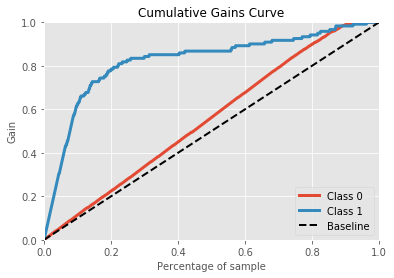

In [184]:
model_rf_best_params_pred_proba = model_rf_best_params.predict_proba(x_test)
skplt.metrics.plot_cumulative_gain(y_test, model_rf_best_params_pred_proba) 

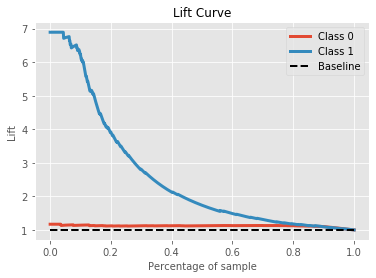

In [185]:
skplt.metrics.plot_lift_curve(y_test, model_rf_best_params_pred_proba)
plt.legend(loc='upper')